In [32]:
import numpy as np 
import pandas as pd
import time 
import timeit
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import interpolate
import matplotlib.pyplot as plt

In [33]:
start = time.time()

In [34]:
dataset = pd.read_csv("dati_LS.csv")
display(dataset)

,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER
0,13.0,1.897417e+09,445.0,24.0,11145.000000,3.0,4.0
1,14.0,1.897417e+09,450.0,9.0,11257.500000,3.0,2.0
2,16.0,1.897417e+09,452.0,17.0,11314.166667,3.0,1.0
3,139.0,1.897417e+09,454.0,0.0,11350.000000,0.0,0.0
4,15.0,1.897417e+09,458.0,9.0,11457.500000,3.0,3.0
...,...,...,...,...,...,...,...
122821,55.0,1.920940e+09,325.0,4.0,8128.333333,3.0,3.0
122822,56.0,1.920940e+09,327.0,22.0,8193.333333,3.0,1.0
122823,139.0,1.920940e+09,329.0,0.0,8225.000000,0.0,0.0
122824,54.0,1.920940e+09,331.0,20.0,8291.666667,3.0,2.0


In [35]:
#ho notato che calcolando direttamente il drift time ci vuole più del doppio del tempo. In questa versione del documento non includo la funzione originale, se serve ce l'ho salvata localmente
df = dataset.copy() #tecnicamente non serve e sicuramente va tolto nella parte 3, ma così posso preservare il dataset senza doverlo ricaricare dal csv in caso di problemi
df["TIME_PEDESTAL"] = np.nan

def assign_time_pedestal(group) :
    t0 = group["TIME"][group.DETECTOR == 0].values #senza il values non funziona perché lavora con serie anziché con strutture di numpy (non so bene perché le serie non vadano)
    group["TIME_PEDESTAL"][group.DETECTOR != 0] = t0 #all'ordine zero t0 è un unico valore in quanto abbiamo filtrato i dati in modo da avere un unico evento e un unico trigger per ogni orbit
    return group

df = df.groupby(['ORBIT_CNT'],group_keys=False)\
                   .apply(assign_time_pedestal)\
                   .reset_index()\
                   .drop(['index'],axis=1) #niente dropna per non perdere i trigger

df["DRIFT_TIME"] = np.abs(df.TIME.values - df.TIME_PEDESTAL)
df["HOR_AMBIG_COORD"] = 42/(2*390)*df.DRIFT_TIME
df

,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER,TIME_PEDESTAL,DRIFT_TIME,HOR_AMBIG_COORD
0,13.0,1.897417e+09,445.0,24.0,11145.000000,3.0,4.0,11350.0,205.000000,11.038462
1,14.0,1.897417e+09,450.0,9.0,11257.500000,3.0,2.0,11350.0,92.500000,4.980769
2,16.0,1.897417e+09,452.0,17.0,11314.166667,3.0,1.0,11350.0,35.833333,1.929487
3,139.0,1.897417e+09,454.0,0.0,11350.000000,0.0,0.0,NaN,NaN,NaN
4,15.0,1.897417e+09,458.0,9.0,11457.500000,3.0,3.0,11350.0,107.500000,5.788462
...,...,...,...,...,...,...,...,...,...,...
122821,55.0,1.920940e+09,325.0,4.0,8128.333333,3.0,3.0,8225.0,96.666667,5.205128
122822,56.0,1.920940e+09,327.0,22.0,8193.333333,3.0,1.0,8225.0,31.666667,1.705128
122823,139.0,1.920940e+09,329.0,0.0,8225.000000,0.0,0.0,NaN,NaN,NaN
122824,54.0,1.920940e+09,331.0,20.0,8291.666667,3.0,2.0,8225.0,66.666667,3.589744


In [36]:
#scarto al volo quelli con drift times troppo grandi
Tmax = 390
experimental_time_uncertainty = 50 #25*2 
T = Tmax + experimental_time_uncertainty

#df = df[df.DRIFT_TIME < T] restituisce in modo velocissimo (è una espressione vettorizzata) solo le righe che soddisfano il nostro criterio; però così spesso eliminiamo abbastanza hits per evento da fare sì
#che non sia più verificata la condizione di almeno 3 hits per evento, quindi riapplico subito la funzione cut vista all'inizio del notebook precedente
print("max drift time within acceptability window:",df[df.DRIFT_TIME < T].DRIFT_TIME.max())

#df = (df[df.DRIFT_TIME < T]).groupby("ORBIT_CNT",group_keys=False).filter(lambda x : len(x) > 2).reset_index().drop(['index'],axis=1) #più lenta rispetto ad apply(cut)

def cut(group) :
    if group.shape[0] > 2 : return group
    else : return None
# questa funzione è molto meno pesante computazionalmente rispetto alla precedente quando applicata al dataset tramite il metodo apply

#filter dataset by length                          
df = (df[df.DRIFT_TIME < T]).groupby(['ORBIT_CNT'],group_keys=False).apply(cut)\
                                                                    .dropna()\
                                                                    .reset_index()\
                                                                    .drop(['index'],axis=1)
df 

max drift time within acceptability window: 438.33333333334303


,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER,TIME_PEDESTAL,DRIFT_TIME,HOR_AMBIG_COORD
0,13.0,1.897417e+09,445.0,24.0,11145.000000,3.0,4.0,11350.0,205.000000,11.038462
1,14.0,1.897417e+09,450.0,9.0,11257.500000,3.0,2.0,11350.0,92.500000,4.980769
2,16.0,1.897417e+09,452.0,17.0,11314.166667,3.0,1.0,11350.0,35.833333,1.929487
3,15.0,1.897417e+09,458.0,9.0,11457.500000,3.0,3.0,11350.0,107.500000,5.788462
4,89.0,1.897417e+09,300.0,27.0,7522.500000,2.0,4.0,7825.0,302.500000,16.288462
...,...,...,...,...,...,...,...,...,...,...
97249,19.0,1.920940e+09,1449.0,2.0,36226.666667,3.0,3.0,36075.0,151.666667,8.166667
97250,55.0,1.920940e+09,325.0,4.0,8128.333333,3.0,3.0,8225.0,96.666667,5.205128
97251,56.0,1.920940e+09,327.0,22.0,8193.333333,3.0,1.0,8225.0,31.666667,1.705128
97252,54.0,1.920940e+09,331.0,20.0,8291.666667,3.0,2.0,8225.0,66.666667,3.589744


Un appunto: nella cella precedente abbiamo imposto che l'incertezza sul drift time fosse 50 ns. Questa in realtà è solo una stima; infatti anche se le incertezze sui tempi "assoluti" sono effettivamente di 25 ns quella sul t0 non si determina altrettanto facilmente (perché stiamo "barando" trattando il trigger elettronico come se fosse uno scintillatore). Se come stima accettiamo per semplicità che anche l'errore su t0 valga 25 ns nella differenza t-t0 richiesta per calcolare il drift time per propagazione degli errori l'incertezza complessiva è di 50 ns.

In [37]:
#%timeit (df[df.DRIFT_TIME < T]).groupby("ORBIT_CNT",group_keys=False).filter(lambda x : len(x) > 2).reset_index().drop(['index'],axis=1)
#2.65 s ± 29.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [38]:
#%timeit (df[df.DRIFT_TIME < T]).groupby(['ORBIT_CNT'],group_keys=False).apply(cut).dropna().reset_index().drop(['index'],axis=1)
#1.6 s ± 25.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

La funzione seguente calcola in modo vettorizzato ed efficiente la colonna "COLUMN", che rappresenta il numero (compreso fra 1 e 16) associato alla cella del layer opportuno del "rettangolo" in cui si trova un dato hit. Per contare le boxes in modo tradizionale bisogna eliminare la convenzione strana di default, il che impone un conteggio layer dependent. In ogni layer da una box a quella immediatamente a destra TDC_CHANNEL salta di +4 unità; pertanto se i TDC_CHANNEL delle boxes consecutive in un fissato layer sono x1,x2,...,x16 dividendo per 4 possiamo mappare la successione `[x1,x2,...,x16]` in quella voluta `[1,2,...,16]` a meno di resto - dovuto al fatto che solo un layer contiene multipli di 4. Per compensare questo resto possiamo sommare/sottrarre un valore layer dependent al TDC_CHANNEL in modo da costruire multipli di 4, dopodiché se dividiamo per 4 e castiamo a intero (in modo di fatto da approssimare per difetto) otteniamo `[0,1,...,15]`, che con un +1 diventa l'intervallo voluto. In questo modo si costruisce la corretta mappa layer dependent dalla successione iniziale a quella voluta (da 1 a 16).  
`BarycentricInterpolator([x1,x2,x3,x4],[y1,y2,y3,y4])` è una interpolazione che dà il polinomio che attraversa i punti `[x1,y1]` eccetera; valutata su layer (cioè proprio in corrispondenza di `[x1,x2,x3,x4]`=`[1,2,3,4]`) ci restituisce i valori layer dependent che ci servono in quanto stiamo valutando il polinomio proprio nei punti utilizzati per costruirlo. Questa operazione è vettorizzata, efficiente e analoga al dic_replace visto nel documento precedente.  
Ovviamente è comodo ricondurre l'intervallo `[65,128]` a quello `[1,64]` in quanto i TDC_CHANNEL che superano 64 lo fanno solo perché si riferiscono ad un altro detector (ma la geometria della mappa discussa finora è la stessa)

In [39]:
#add column coordinate of the cell
def minus64(x):
    #if x <= 64:
    if x < 65: #più performante e ne ho le prove. cfr il grande Marco Russo
        return x
    else:
        return x - 64

#il comando originale è impreciso, permette che alcune colonne siano 0 anziché 1. Lo rifaccio con lo stesso comando ma sommando il termine analogo a dic_replace (ma senza %4=...)   
#df['COLUMN'] = ((df['TDC_CHANNEL'].apply(minus64) - interpolate.BarycentricInterpolator([1,2,3,4],[1,3,2,4])(df['LAYER'])) / 4 + 1).astype(int)

#impongo che il polinomio interpolatore passi per (1,0),(2,2),(3,1),(4,3) perché se voglio usare la formula (1/4)*(TDC_CHANNEL+f(LAYER)) il fattore f(LAYER) deve essere 0 quando layer=1, 2 quando layer=2, 1 quando layer=3, 3 quando layer=4. Questi valori sono gli stessi usati da Lorenzo, Samuele e Mattia altrove, e si ricavano "ricostruendo" i multipli di 4 riga per riga
df["COLUMN"] = ((df['TDC_CHANNEL'].apply(minus64) + interpolate.BarycentricInterpolator([1,2,3,4],[0,2,1,3])(df["LAYER"])) / 4).astype(int)
df

,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER,TIME_PEDESTAL,DRIFT_TIME,HOR_AMBIG_COORD,COLUMN
0,13.0,1.897417e+09,445.0,24.0,11145.000000,3.0,4.0,11350.0,205.000000,11.038462,4
1,14.0,1.897417e+09,450.0,9.0,11257.500000,3.0,2.0,11350.0,92.500000,4.980769,4
2,16.0,1.897417e+09,452.0,17.0,11314.166667,3.0,1.0,11350.0,35.833333,1.929487,4
3,15.0,1.897417e+09,458.0,9.0,11457.500000,3.0,3.0,11350.0,107.500000,5.788462,4
4,89.0,1.897417e+09,300.0,27.0,7522.500000,2.0,4.0,7825.0,302.500000,16.288462,7
...,...,...,...,...,...,...,...,...,...,...,...
97249,19.0,1.920940e+09,1449.0,2.0,36226.666667,3.0,3.0,36075.0,151.666667,8.166667,5
97250,55.0,1.920940e+09,325.0,4.0,8128.333333,3.0,3.0,8225.0,96.666667,5.205128,14
97251,56.0,1.920940e+09,327.0,22.0,8193.333333,3.0,1.0,8225.0,31.666667,1.705128,14
97252,54.0,1.920940e+09,331.0,20.0,8291.666667,3.0,2.0,8225.0,66.666667,3.589744,14


In [40]:
#%timeit df['COLUMN'] = ((df['TDC_CHANNEL'].apply(minus64) - interpolate.BarycentricInterpolator([1,2,3,4],[1,3,2,4])(df['LAYER'])) / 4 + 1).astype(int)
#38.7 ms ± 480 µs per loop (mean ± std. dev. of 7 runs, 10 loops each) con il <=, 37.9 ms ± 525 µs per loop (mean ± std. dev. of 7 runs, 10 loops each) con il <

In [41]:
#preso da Mattia MA RITOCCATO IN MODO DA RISPETTARE LA NOSTRA CONVENZIONE SUI LAYERS!
def event_plot(event):
    
    fig,ax1 = plt.subplots(figsize=(1.5*4.2*17,1.5*1.3*6))
    
    #dimensions of one cell
    dx = 42
    dy = 13
    
    x = [] #le liste delle coordinate dei * nel grafico finale
    y = []
    for i in range(len(event)):
        hit = event.iloc[i] #prendo l'hit i dell'evento considerato
        #y1 = dy * (4 - hit.LAYER + 1/2) #altra convenzione
        y1 = dy * (hit.LAYER-1/2) #layer 1: altezza dy*1/2, layer 2: altezza dy*(1+1/2)=dy*3/2, layer 3: dy*(2+1/2)=dy*5/2, layer 4: dy*(3+1/2)=dy*7/2
        #allora va ben come formula y1 = dy/2 * (2*hit.LAYER-1); quella sopra è equivalente ma più efficiente
        y.append(y1) #i punti a destra e a sinistra relativi alla hit i immaginiamo si trovino a metà della cella (l'unica informazione fisica che abbiamo è orizzontale)
        y.append(y1) #y1 va aggiunto due volte: una volta per l'ambiguità destra e una per la sinistra

        #adesso bisogna aggiungere x1 e x2 (destra e sinistra del nostro hit). NOTA IMPORTANTE: a differenza che in centers qui l'origine è il punto in basso a sinistra dell'apparato sperimentale anziché essere distante da esso
        #if hit.LAYER % 2 == 0 :
            # x1 = dx * (hit.COLUMN - 1/2) + hit.X #altra convenzione, dove i layer pari sono traslati a sinistra; nella nostra sono traslati verso destra (e infatti l'if è opposto al mio)
            # x2 = dx * (hit.COLUMN - 1/2) - hit.X 
            #column = numero della cella fra 1 e 16 fissato il layer = se moltiplicata per un multiplo di dx dà coordinata del centro della box
        if hit.LAYER % 2 != 0 : #mi viene meglio fare prima il caso senza traslazione
            x1 = dx * (hit.COLUMN - 1/2) + hit.X #stessa formula di prima +- X
            x2 = dx * (hit.COLUMN - 1/2) - hit.X
            x.append(x1)
            x.append(x2)
        else :
            x1 = dx * hit.COLUMN + hit.X #qui devo sommare dx/2 per tenere conto della traslazione dei layer 2 e 4 (nella nostra convenzione), quindi il -1/2 di prima si semplifica 
            x2 = dx * hit.COLUMN - hit.X 
            x.append(x1)
            x.append(x2)
            

    #draw the detector
    ax1.set_xlim(0,42*16 + 42)
    ax1.set_ylim(-13,13*4 + 13)

    #adesso che ho le coordinate con ambiguità di tutte le hits di un dato evento devo disegnarle collettivamente in un unico detector

    # #coordinates of layer 1, not 4 anymore
    # #x_1 = np.arange(1,17)*42-dx
    # x_1 = np.arange(16)*dx #è equivalente alla riga precedente ma più veloce ed intuitivo dire che in queste coordinate il lato sinistro delle celle è a 0*dx,1*dx,2*dx,...,15*dx
    # y_1 = 0 #lato basso del layer 1 secondo noi = altezza nulla
    
    # #coordinates of layer 2, not 3 anymore
    # x_2 = x_1 + dx/2 #bisogna traslare di dx/2 a destra 
    # y_2 = dy #l'estremo in basso a destra del secondo layer nella nostra convenzione ha altezza dy
    
    # #coordinates of layer 3, not 2 anymore
    # x_3 = x_1
    # y_3 = 2*dy
    
    # #coordinates of layer 1
    # x_4 = x_2
    # y_4 = 3*dy

    #facendo riferimento alle righe qui sopra per interpretare quelle immediatamente seguenti secondo me facciamo prima così:
    x_1 = x_3 = np.arange(16)*dx #array con 16 elementi
    x_2 = x_4 = x_1 + dx/2
    [y_1, y_2, y_3, y_4] = np.arange(4)*dy #scalari. Uso array anziché liste per potere moltiplicare per lo scalare dy senza problemi (credo)
    
    for i in range(16):
        rect = patches.Rectangle((x_1[i],y_1),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
    
        rect = patches.Rectangle((x_2[i],y_2),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
    
        rect = patches.Rectangle((x_3[i],y_3),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
        
        rect = patches.Rectangle((x_4[i],y_4),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
        
        ax1.axis('off')
        
    ax1.scatter(x,y, marker = 'x', c = 'red', s = 500, linewidth = 7)
    return ax1

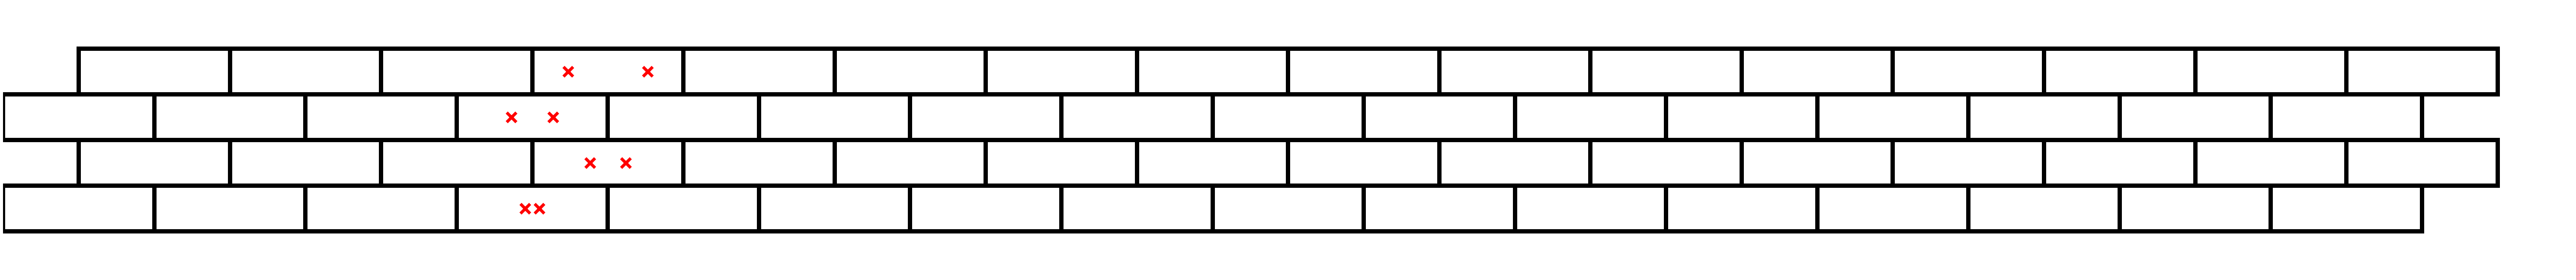

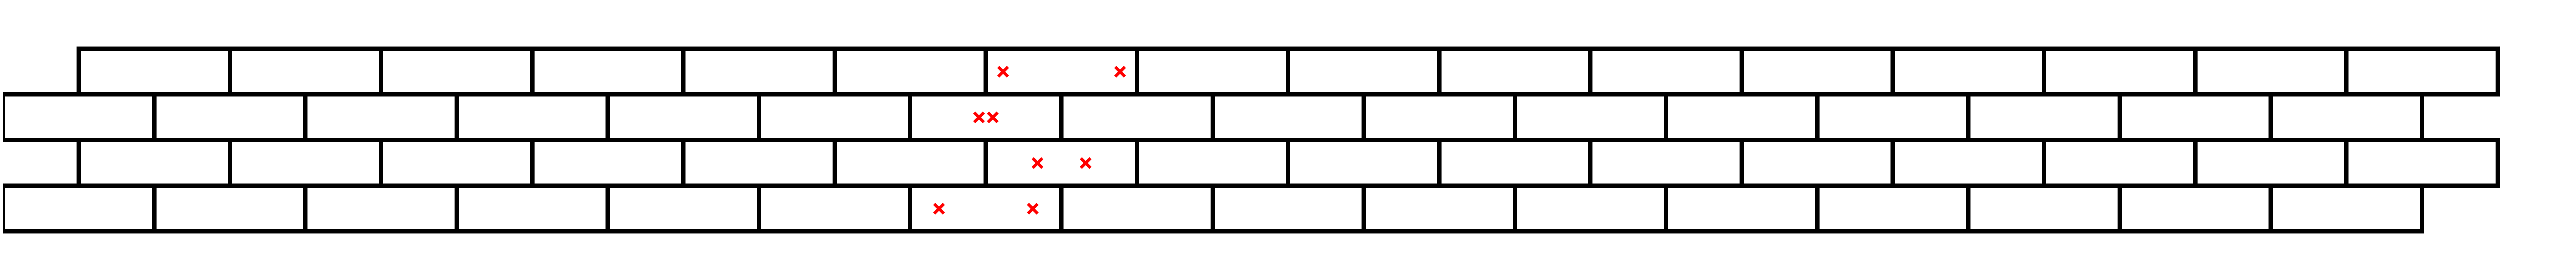

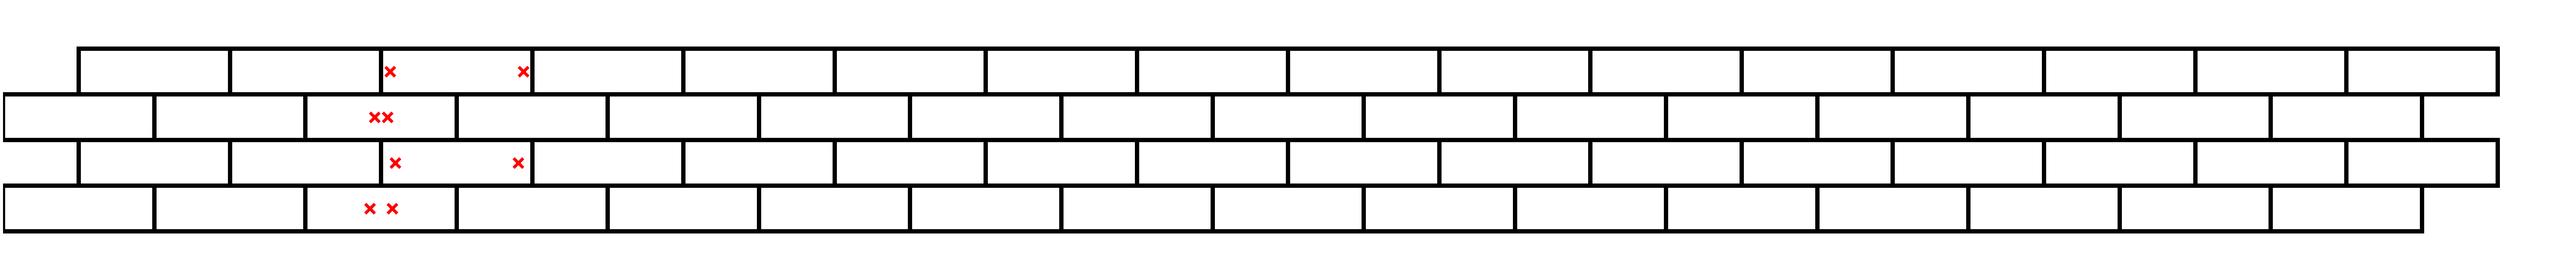

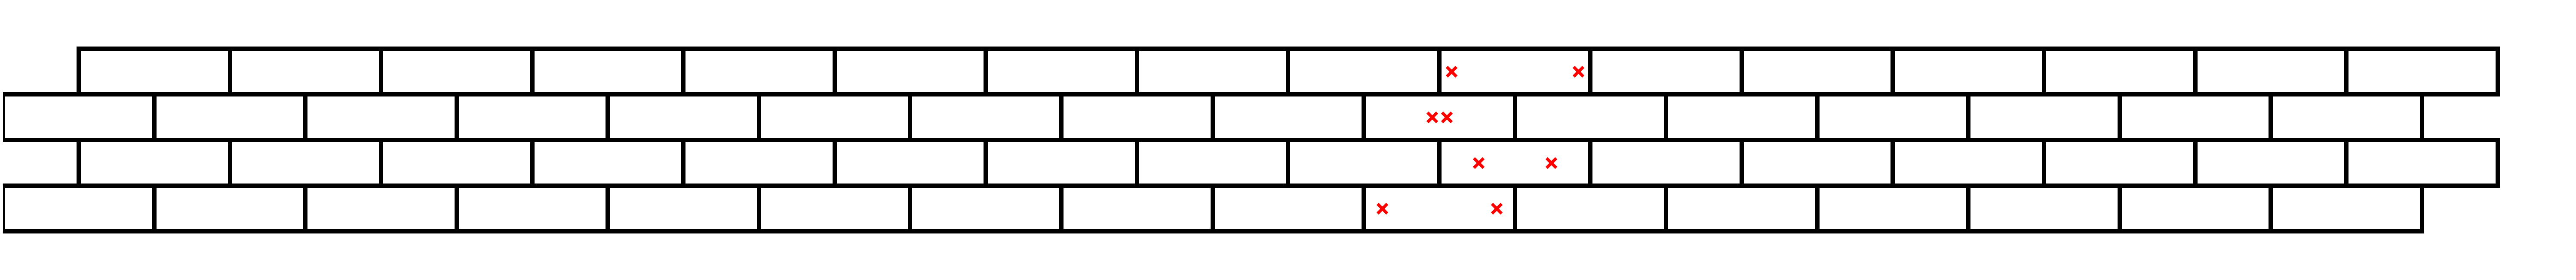

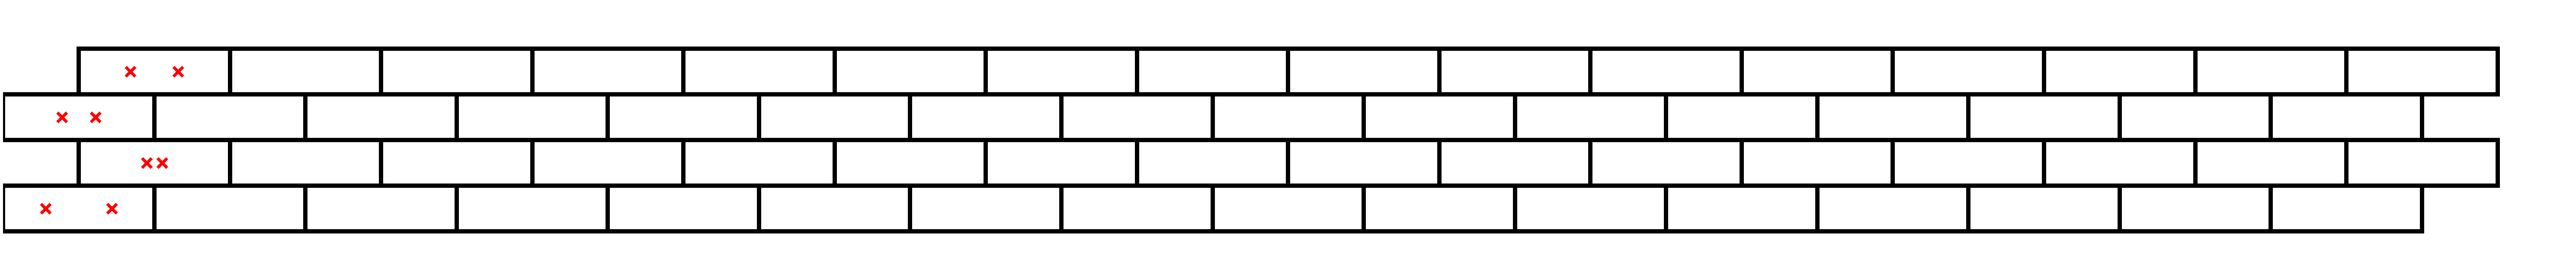

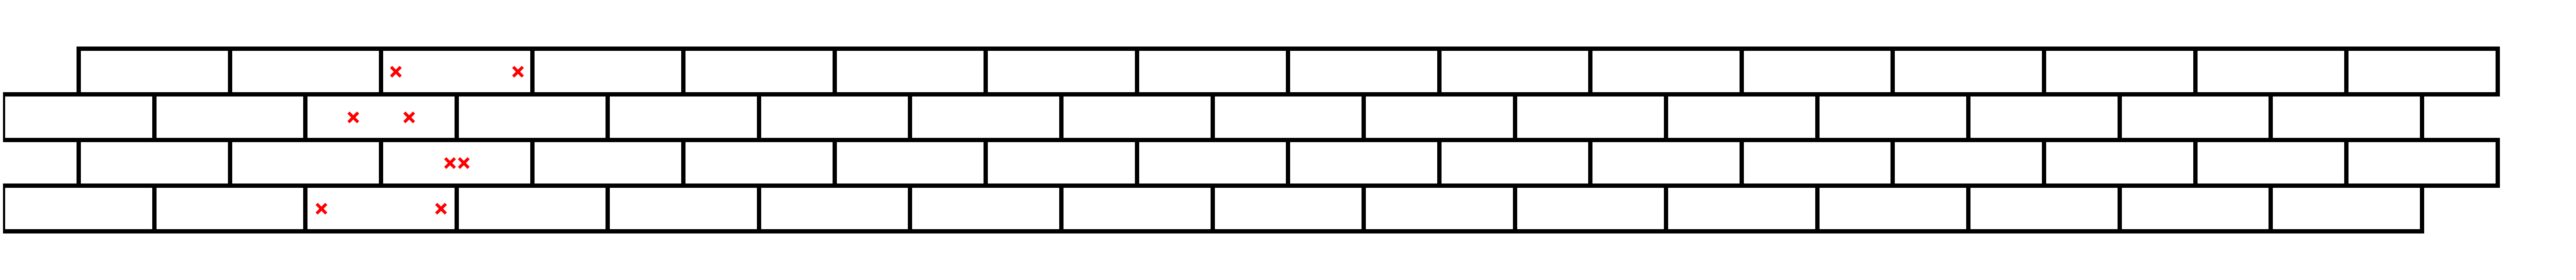

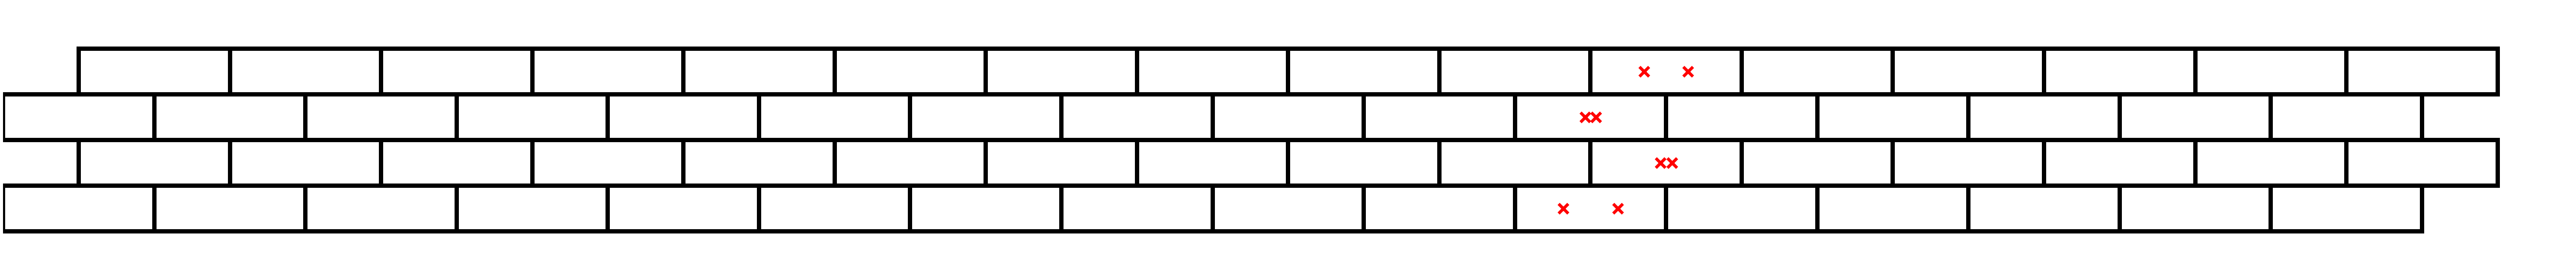

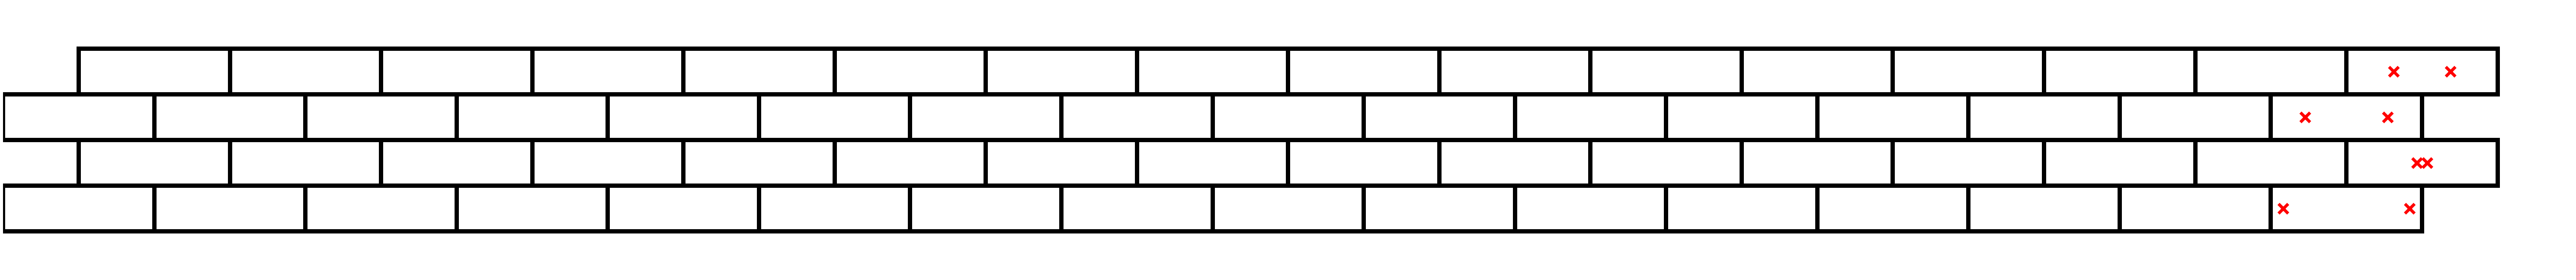

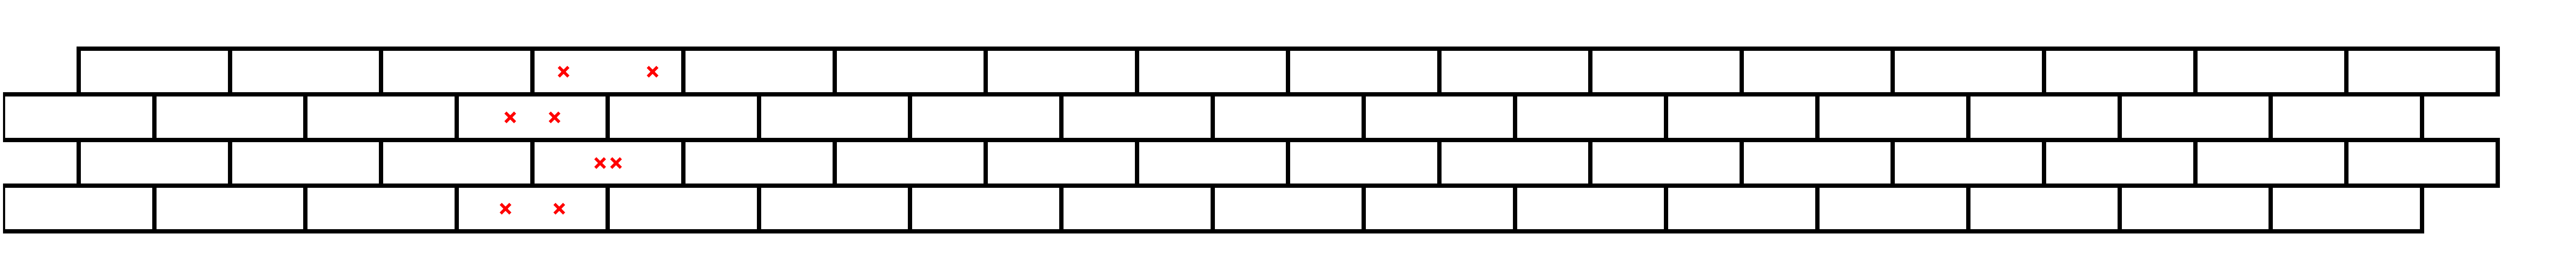

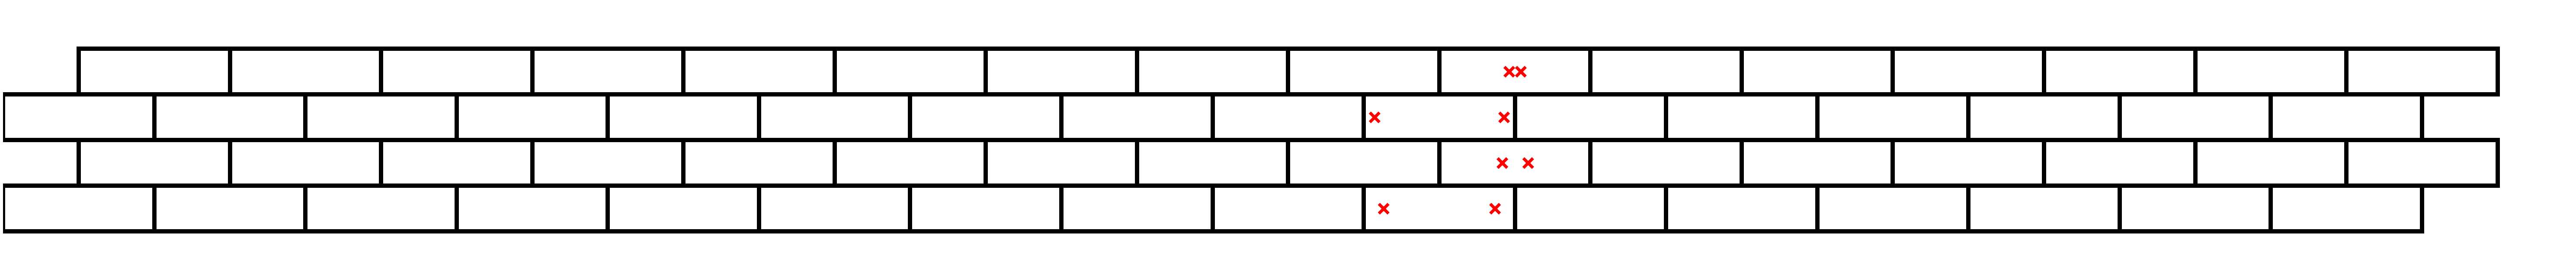

In [42]:
#preso paro paro da Mattia. Nota: dovrebbe essere solido sia all'ordine 0 che 2
#per coerenza con Mattia e per semplicità rinomino la colonna seguente adattandomi alla sua convenzione
df.rename(columns={"HOR_AMBIG_COORD":"X"},inplace=True)

for i in np.unique(df.ORBIT_CNT.values)[:10]:
    try:
        event = df.groupby(['ORBIT_CNT','EVENT']).get_group((i,1))
        event_plot(event)
    except:
        event = df.groupby(['ORBIT_CNT']).get_group(i)
        event_plot(event)

Nota importante: le rette non possono essere tracciate esattamente in molti dei grafici qui sopra, però effettivamente tenendo conto dell'errore sperimentale probabilmente molti di questi (se non tutti) si possono salvare. Penso che la cosa più semplice sia fare dei fit anziché usare equazioni esatte ed utilizzare i residui per valutare se lo scarto è entro l'accettabilità dell'errore sperimentale!

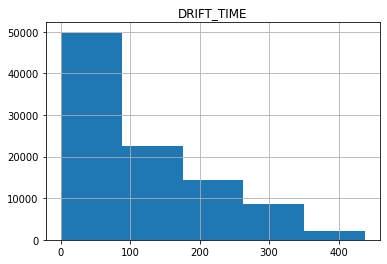

In [43]:
df.hist(column = 'DRIFT_TIME',bins=5);

Riguardo all'istogramma appena ottenuto penso questo: tutto sommato mi sta bene che non sia una distribuzione uniforme! Infatti avere tanti drift times lunghi vuol dire rette molto inclinate - che noi stiamo sfavorendo moltissimo con tutti i filtri applicati finora, che sono pensati per "rispettare" soprattutto le rette quasi verticali.

In [44]:
stop = time.time()
print("total execution time (s):", stop-start)

total execution time (s): 57.793930530548096


In [45]:
#df.to_csv("dati_MM.csv",index=False)